In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

In [2]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
import requests
import pickle

def load_data():
    # return fetch_ucirepo(id=296)
    response = requests.get('https://assets.yongjun.sg/diabetes_dataset.pkl')
    dataset = pickle.loads(response.content)
    return dataset

In [4]:
dataset = load_data()
data = dataset.data.original

In [5]:
data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [6]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

### Tain / Test Split

In [7]:
y = data['readmitted'] == "<30"
g = data['patient_nbr']
X = data.drop(columns=['encounter_id', 'readmitted'])

In [8]:
seed = 777

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)

k_fold_split = [test_index for _, test_index in sgkf.split(X, y, g)]

#### Validate k-fold split have non-overlapping patient

In [9]:
k_fold_patient_count = [len(g[test_index].value_counts()) for test_index in k_fold_split]
sum(k_fold_patient_count) == len(g.value_counts())

True

### Numeric Features

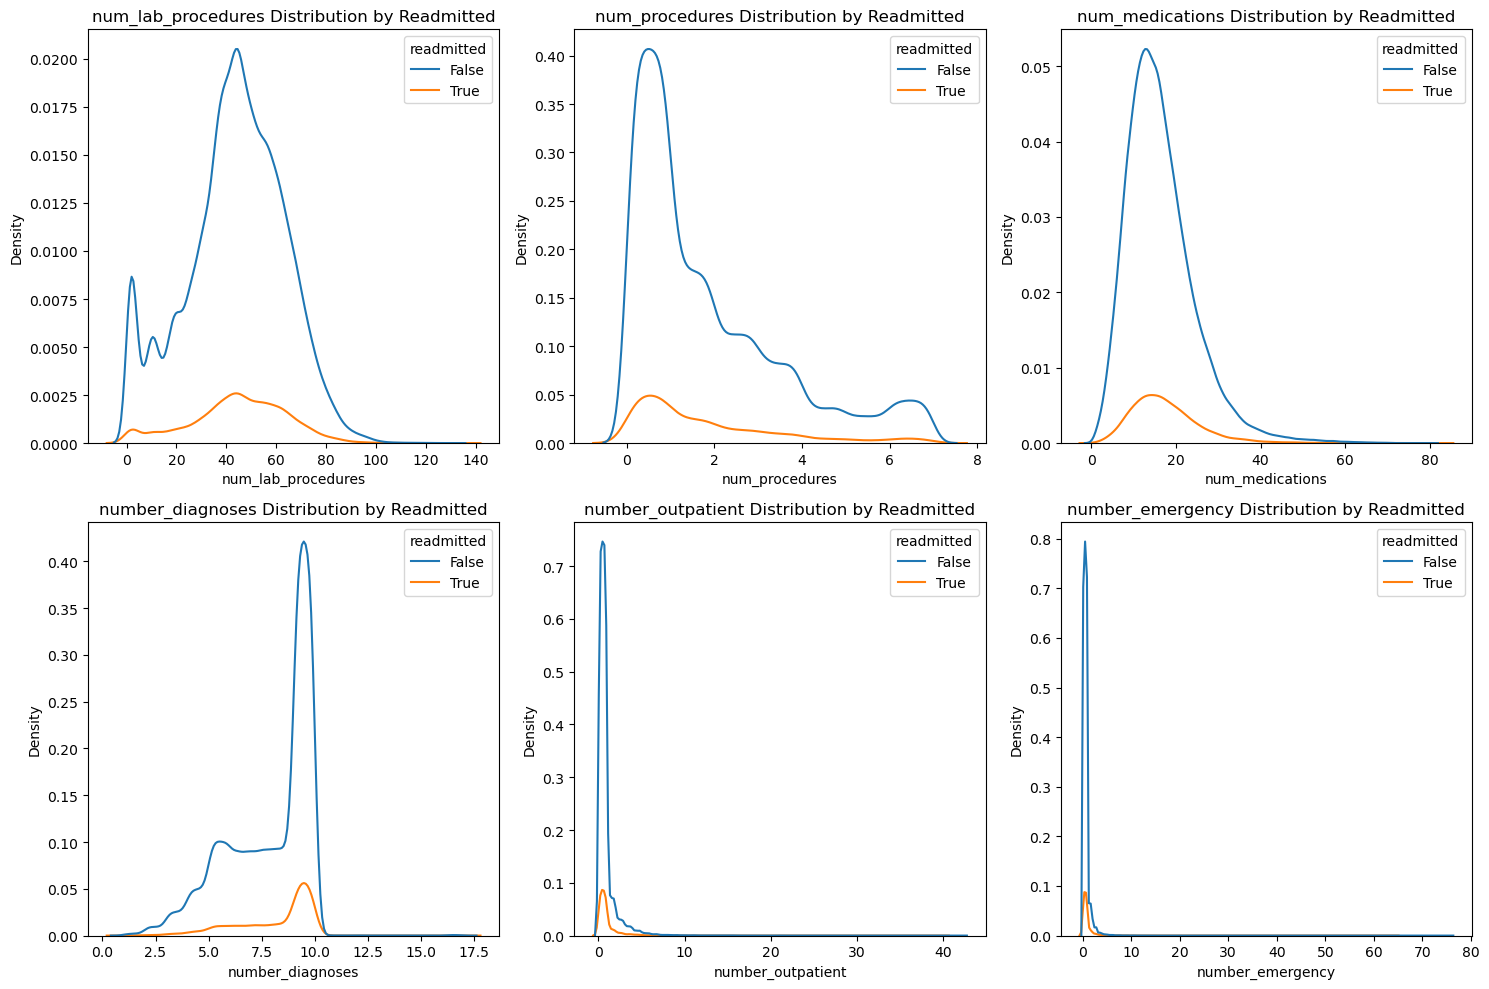

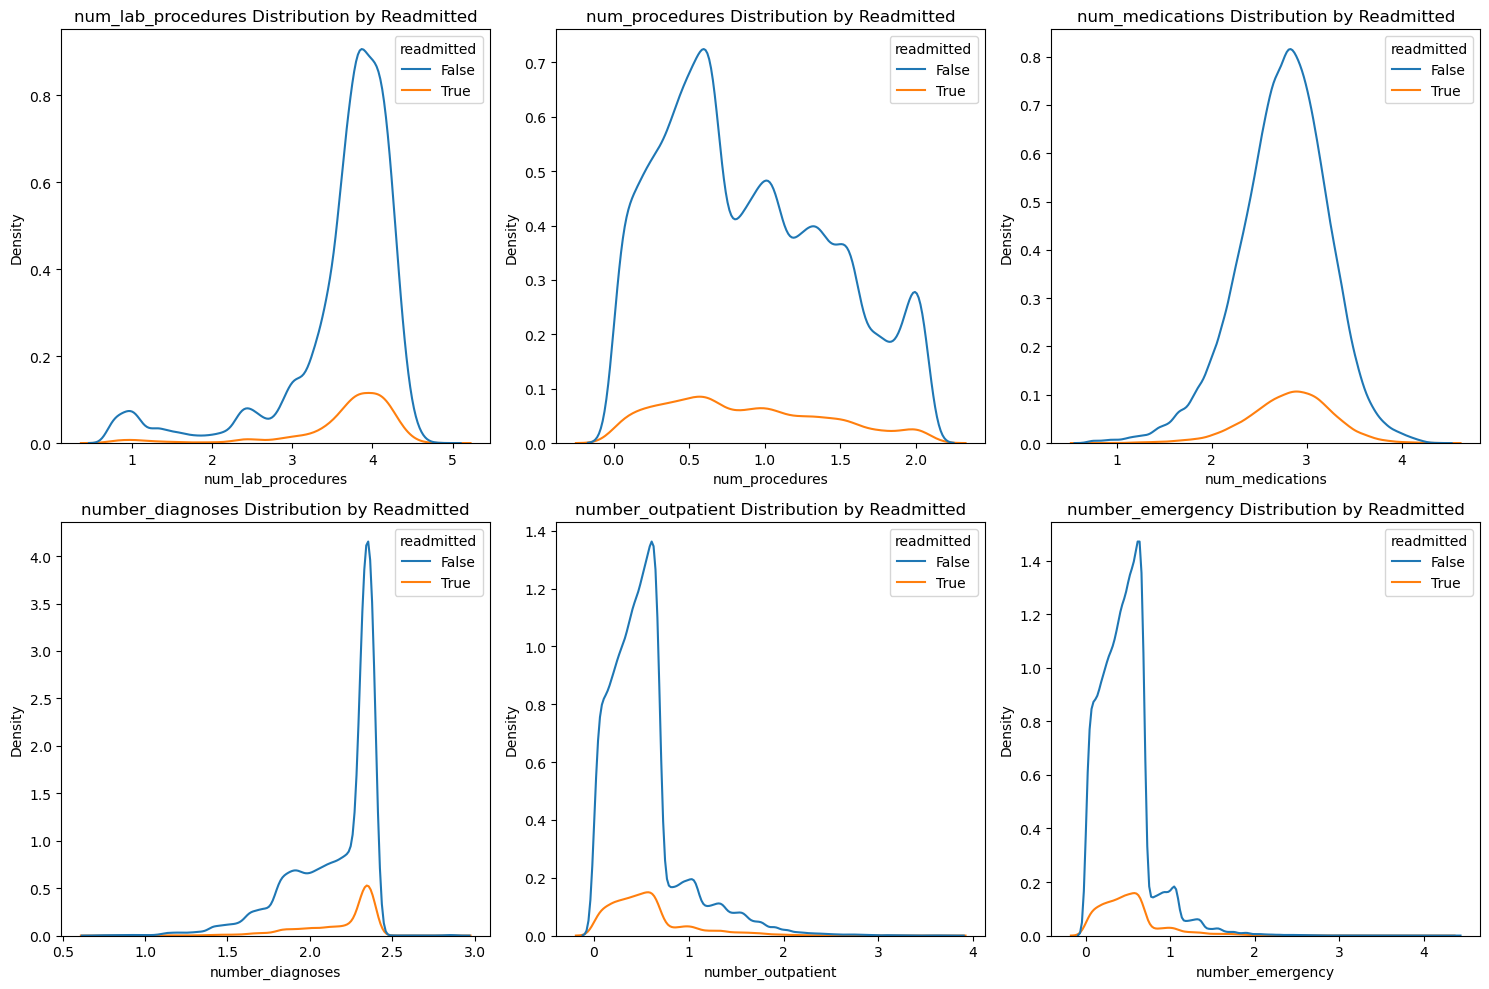

In [10]:
numeric_features = [
    'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'time_in_hospital'
]

def plot_numeric_feature(X, y, log=False):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    jitter = np.random.uniform(0, 1, len(X))

    for ax, feature in zip(axes.ravel(), numeric_features):
        x = np.log(data[feature] + jitter + 1) if log else data[feature] + jitter
        sns.kdeplot(x=x, hue=y, ax=ax)
        ax.set_title(f'{feature} Distribution by Readmitted')

    plt.tight_layout()

plot_numeric_feature(X, y, False)
plot_numeric_feature(X, y, True)


In [11]:
numeric_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

### Catergorical Feature

In [12]:
categorical_features = [
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'medical_specialty', 'max_glu_serum', 'A1Cresult'
]

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### Demographic Features

In [13]:
demo_features = ['race', 'gender', 'age']

for feature in demo_features:
    X[feature] = X[feature].astype('category')

patient_encounter = data['patient_nbr'].value_counts()
w = 1.0 / data['patient_nbr'].map(patient_encounter)

# Sort race categories by frequency
race_sorted = w.groupby(data['race']).sum().sort_values(ascending=False)
X['race'] = X['race'].cat.reorder_categories(list(race_sorted.index))

# Assign missing value race to the mode
mode_race = race_sorted.index[0]
X['race'] = X['race'].fillna(mode_race)

# Set unknown gender as baseline
X['gender'] = X['gender'].cat.reorder_categories(['Unknown/Invalid', 'Female', 'Male'])


In [14]:
class DemographicInteractionTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that:
    1. Applies one-hot encoding to demographic features
    2. Creates pairwise interactions between original demographic features (not between one-hot encoded features)
    """
    
    def __init__(self):
        self.onehot_encoders = {}
        self.feature_names_ = None
        
    def fit(self, X, y=None):
        # Fit one-hot encoders for each demographic feature
        for feature in X.columns:
            # Get the categories in the order they appear in the pandas Categorical
            if hasattr(X[feature].dtype, 'categories'):
                categories = [X[feature].dtype.categories.tolist()]
            else:
                categories = 'auto'
            
            encoder = OneHotEncoder(
                handle_unknown='ignore', 
                drop='first', 
                sparse_output=False,
                categories=categories
            )
            encoder.fit(X[[feature]])
            self.onehot_encoders[feature] = encoder
        
        # Generate feature names for the final output
        self._generate_feature_names(X)
        return self
    
    def transform(self, X):
        # Apply one-hot encoding to each demographic feature
        encoded_features = []
        feature_names = []
        
        for feature in X.columns:
            encoded = self.onehot_encoders[feature].transform(X[[feature]])
            encoded_features.append(encoded)
            
            # Get feature names for this feature
            feature_names.extend(self.onehot_encoders[feature].get_feature_names_out([feature]))
        
        # Create pairwise interactions between original demographic features
        interaction_features = []
        interaction_names = []
        
        for feat1, feat2 in combinations(X.columns, 2):
            # Get the one-hot encoded features for both original features
            encoded1 = self.onehot_encoders[feat1].transform(X[[feat1]])
            encoded2 = self.onehot_encoders[feat2].transform(X[[feat2]])
            
            # Create interactions between all pairs of one-hot encoded features
            for i in range(encoded1.shape[1]):
                for j in range(encoded2.shape[1]):
                    interaction = encoded1[:, i] * encoded2[:, j]
                    interaction_features.append(interaction.reshape(-1, 1))
                    
                    # Get feature names for the interaction
                    feat1_name = self.onehot_encoders[feat1].get_feature_names_out([feat1])[i]
                    feat2_name = self.onehot_encoders[feat2].get_feature_names_out([feat2])[j]
                    interaction_names.append(f"{feat1_name} x {feat2_name}")
        
        # Combine all features
        all_features = encoded_features + interaction_features
        result = np.hstack(all_features)
        
        return result
    
    def _generate_feature_names(self, X):
        """Generate feature names for the final output"""
        feature_names = []
        
        # Add one-hot encoded feature names
        for feature in X.columns:
            feature_names.extend(self.onehot_encoders[feature].get_feature_names_out([feature]))
        
        # Add interaction feature names
        for feat1, feat2 in combinations(X.columns, 2):
            feat1_names = self.onehot_encoders[feat1].get_feature_names_out([feat1])
            feat2_names = self.onehot_encoders[feat2].get_feature_names_out([feat2])
            
            for name1 in feat1_names:
                for name2 in feat2_names:
                    feature_names.append(f"{name1} x {name2}")
        
        self.feature_names_ = feature_names
    
    def get_feature_names_out(self):
        return self.feature_names_

# Create the demographic transformer
demo_transformer = DemographicInteractionTransformer()

### Medication features

In [15]:
medication_features = data.columns[24:47]
medication_prevalence = (data[medication_features] != 'No').sum().sort_values(ascending=False)
sorted_medication_features = list(medication_prevalence.index)

medication_transformer = Pipeline(steps=[
    ('medication_encoder', FunctionTransformer(
        lambda X: pd.DataFrame({
            **{col + '_yes': X[col].isin(['Down', 'Steady', 'Up']).astype(int) 
               for col in X.columns},
            **{col + '_up': (X[col] == 'Up').astype(int)
               for col in X.columns}
        })
    ))
])

### Dianogsis Features

In [16]:
diagnosis_features = ['diag_1', 'diag_2', 'diag_3', 'patient_nbr']

class DiagnosisPCATransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that:
    1. Combines diag_1, diag_2, diag_3 with OR operation
    2. Groups by patient and combines diagnoses using max operation
    3. Applies PCA and returns first 200 components
    """
    
    def __init__(self, n_components=200):
        self.n_components = n_components    # For returning components in transform
        self.diag_categories_ = None
        self.pca_ = None
        
    def fit(self, X, y=None):
        """
        Fit the transformer on training data
        X should contain diag_1, diag_2, diag_3 columns and patient_nbr column
        """
        # Get all unique diagnosis categories from training data
        all_diag_categories = pd.concat([X['diag_1'], X['diag_2'], X['diag_3']]).unique()
        # Remove None/NaN values
        all_diag_categories = all_diag_categories[pd.notna(all_diag_categories)]
        
        # Convert to categorical with all possible categories (following EDA approach)
        diag_1_cat = pd.Categorical(X['diag_1'], categories=all_diag_categories)
        diag_2_cat = pd.Categorical(X['diag_2'], categories=all_diag_categories)
        diag_3_cat = pd.Categorical(X['diag_3'], categories=all_diag_categories)
        
        # Create one-hot encodings for each diagnosis column
        diag_1_oh = pd.get_dummies(diag_1_cat, dtype=int)
        diag_2_oh = pd.get_dummies(diag_2_cat, dtype=int)
        diag_3_oh = pd.get_dummies(diag_3_cat, dtype=int)
        
        # Combine diagnosis one-hot encodings with OR operation
        diag_oh_combined = diag_1_oh + diag_2_oh + diag_3_oh
        
        # Get the most frequent diagnosis
        most_freq_diag = diag_oh_combined.sum().sort_values(ascending=False).index
        
        # Create dataframe with patient numbers and diagnosis one-hot encodings
        patient_diag_oh = pd.concat([X['patient_nbr'], diag_oh_combined], axis=1)
        
        # Group by patient and combine using max (equivalent to OR for binary values)
        patient_grouped_diag_oh = patient_diag_oh.groupby('patient_nbr').max()
        patient_grouped_diag_oh = (patient_grouped_diag_oh > 0).astype(int)
        
        # Fit PCA on patient-grouped diagnosis data
        # Number of components should be based on the number of diagnosis categories
        n_components = len(most_freq_diag)
        self.diag_categories_ = list(most_freq_diag)
        self.pca_ = PCA(n_components=n_components)
        self.pca_.fit(patient_grouped_diag_oh[most_freq_diag])
        
        return self
    
    def transform(self, X):
        """
        Transform the data using the fitted transformer
        X should contain diag_1, diag_2, diag_3 columns
        """
        # Convert to categorical with trained categories (following EDA approach)
        diag_1_cat = pd.Categorical(X['diag_1'], categories=self.diag_categories_)
        diag_2_cat = pd.Categorical(X['diag_2'], categories=self.diag_categories_)
        diag_3_cat = pd.Categorical(X['diag_3'], categories=self.diag_categories_)
        
        # Create one-hot encodings for each diagnosis column
        # Unseen values will be NaN and get dropped, resulting in all zeros
        diag_1_oh = pd.get_dummies(diag_1_cat, dtype=int)
        diag_2_oh = pd.get_dummies(diag_2_cat, dtype=int)
        diag_3_oh = pd.get_dummies(diag_3_cat, dtype=int)
        
        # Combine diagnosis one-hot encodings with OR operation (using max for binary consistency)
        diag_oh_combined = np.maximum(diag_1_oh, np.maximum(diag_2_oh, diag_3_oh))
    
        
        # Apply the fitted PCA transformation directly to encounter-level data
        pca_result = self.pca_.transform(diag_oh_combined)
        
        # Return only the first n_pc_return components
        return pca_result[:, :self.n_components]

diagnosis_transformer = DiagnosisPCATransformer(n_components=200)

### Compose

In [17]:
# Create the complete preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Numeric features: log transform + standardize
        ('numeric', numeric_transformer, numeric_features),

        ('categorical', categorical_transformer, categorical_features),
        
        # Demographic features: one-hot + interactions
        ('demo', demo_transformer, demo_features),
        
        # Medication features: binary encoding
        ('medication', medication_transformer, sorted_medication_features),
        
        # Diagnosis features: PCA with 200 components
        ('diagnosis', diagnosis_transformer, diagnosis_features)
    ],
    remainder='drop'  # Drop any remaining columns
)